In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

# %pylab inline
# % config InlineBackend.figure_format = 'svg'

import pandas as pd
import seaborn as sns
sns.set()



from clean3 import clean_games

pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 73)

In [2]:
df = clean_games('data/games.pickle', start_year=1990)

In [21]:
game_df = df.copy()

In [22]:
selected_columns = [
 'season_year',
 'week_num', 
 'team_home_game',
 'ewma_margin',
 'ewma_margin_opp',
 'ewma_pass_rating',
 'ewma_pass_rating_opp',
 'ewma_pass_td',
 'ewma_pass_td_opp',
 'ewma_rush_td',
 'ewma_rush_td_opp',
]

In [23]:
X = game_df[selected_columns]
y = game_df['margin']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5971 entries, 12 to 56648
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season_year           5971 non-null   int64  
 1   week_num              5971 non-null   float64
 2   team_home_game        5971 non-null   float64
 3   ewma_margin           5971 non-null   float64
 4   ewma_margin_opp       5971 non-null   float64
 5   ewma_pass_rating      5971 non-null   float64
 6   ewma_pass_rating_opp  5971 non-null   float64
 7   ewma_pass_td          5971 non-null   float64
 8   ewma_pass_td_opp      5971 non-null   float64
 9   ewma_rush_td          5971 non-null   float64
 10  ewma_rush_td_opp      5971 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 559.8 KB


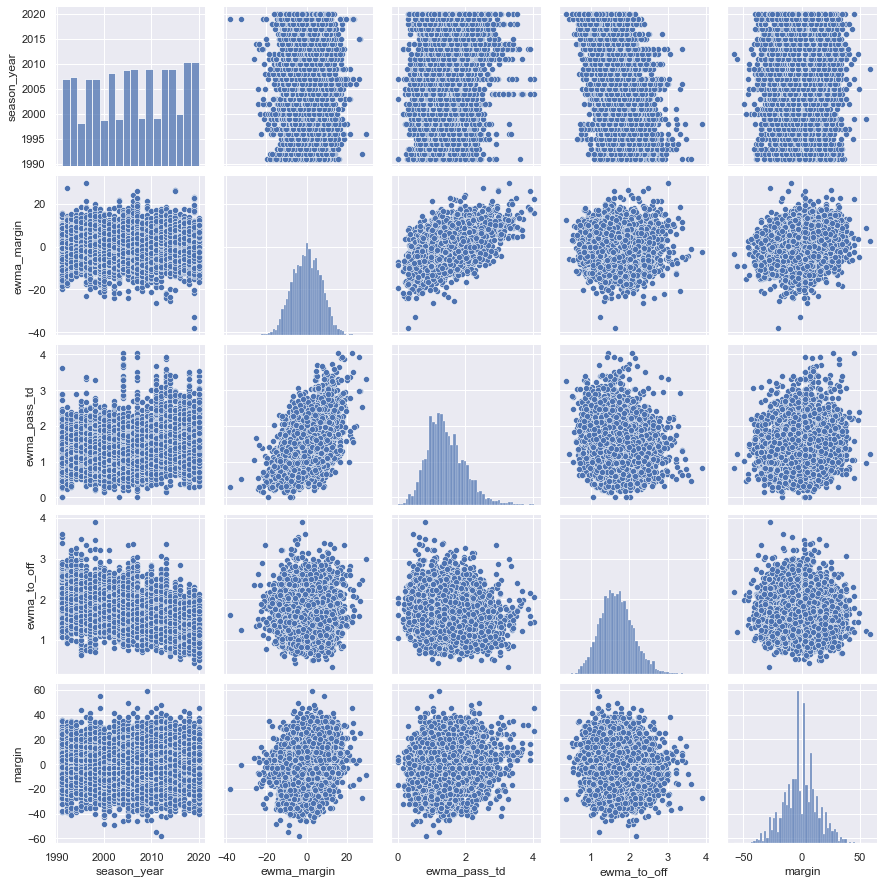

In [24]:

sns.pairplot(game_df[['season_year', 'ewma_margin', 'ewma_pass_td',
                      'ewma_to_off', 'margin']])


## Ridge Regression

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [30]:
np.random.seed(6)

X_train_collinear = game_df[[selected_columns]]
X_train_collinear['Lot Area Clone'] = (X_train_collinear[selected_columns] + 
                                      2500 * np.random.randn(X_train.shape[0]))

X_train_collinear.corr() #notice .95 correlation b/w Lot Area and its "clone"

KeyError: "None of [Index([('season_year', 'week_num', 'team_home_game', 'ewma_margin', 'ewma_margin_opp', 'ewma_pass_rating', 'ewma_pass_rating_opp', 'ewma_pass_td', 'ewma_pass_td_opp', 'ewma_rush_td', 'ewma_rush_td_opp')], dtype='object')] are in the [columns]"

In [37]:
lr_model_ridge = Ridge(alpha = 100000)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

[('season_year', 0.016921791834298847),
 ('week_num', 0.01475131516716004),
 ('team_home_game', 0.05163493109940296),
 ('ewma_margin', 0.20708643840591895),
 ('ewma_margin_opp', -0.27212864036591194),
 ('ewma_pass_rating', 0.11192758981009614),
 ('ewma_pass_rating_opp', -0.09870437229047258),
 ('ewma_pass_td', 0.006149677226235378),
 ('ewma_pass_td_opp', 0.0004630335858811453),
 ('ewma_rush_td', 0.00822977616926588),
 ('ewma_rush_td_opp', -0.011520604143534815)]

In [33]:
lr_model_ridge.score

<bound method RegressorMixin.score of Ridge(alpha=1000000000000)>

## Simple Validation: Train/Test Split

First, put 20% aside for testing. Then, split the remaining 80% into 60/20 train/validate.

In [7]:
# hold out 20% of the data for final testing
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# split the remaining 80% into 60:20 train:validate split
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

## Create Scaled Features

In [8]:
lm = LinearRegression()

#Feature scaling for train, val, and test
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

## Create Polynomial Features

This multiplies each feature by one another.

In [9]:
#Feature transforms for train, val, and test so that we can run our poly model on each
# I think this is the one where it multiplies each by each other?
poly = PolynomialFeatures(degree=3)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [10]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.132
Degree 2 polynomial regression val R^2: 0.064


In [11]:
lm.fit(X_,y_)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.150


## K-Fold Cross-Validation

Train test split, again.

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [13]:
# run the cross-validation
#ew - random state is just for reproducability
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results


    # uncomment below cell to see what's happening in this loop
    # it's returning the indeces of the rows in each group
for train_ind, val_ind in kf.split(X,y):
    print(len(train_ind), len(val_ind))

3820 956
3821 955
3821 955
3821 955
3821 955


## Simple Linear Regression model using K-Fold

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X,y):
    # this will return the indeces of the rows in each group
    # ALL DATA CLEANING GOES INTO THIS LOOP!!
        # USE FUNCS
    
    # save scores in output of the model    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

Simple regression scores:  [0.155, 0.116, 0.128, 0.165, 0.156] 

Simple mean cv r^2: 0.144 +- 0.019


## Polynomial Regression model using K-Fold

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_poly_r2s = []

for train_ind, val_ind in kf.split(X,y):
    # need to re-split each time we do this
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #poly with degree 2
    poly = PolynomialFeatures(degree=2)

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    
    lm_poly.fit(X_train_poly, y_train)
    cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
print('Poly scores: ', cv_lm_poly_r2s, '\n')

print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')

Poly scores:  [0.145, 0.112, 0.124, 0.166, 0.087] 

Poly mean cv r^2: 0.127 +- 0.027


In [16]:
lm_poly.coef_

array([-9.97930044e+09, -1.44514482e+01,  1.76952797e+01,  1.43663785e+02,
       -1.32375292e+01,  2.33603868e+01, -6.55564535e+00,  9.09911321e+00,
        2.77899679e+02, -1.55089409e+02,  9.46600639e+01, -2.62029442e+02,
        3.69194977e-03, -9.42381912e-03, -1.37208010e-01,  6.37010098e-03,
       -1.22890937e-02,  3.16545525e-03, -5.07110485e-03, -1.35429911e-01,
        9.38780125e-02, -3.55938672e-02,  1.28345751e-01, -9.05410498e-03,
        2.03908247e-01,  1.14509736e-02, -2.99772244e-02,  2.65891381e-02,
        1.14628212e-02, -6.12431418e-01, -2.44777372e-01, -1.11714430e-01,
       -5.93161037e-01,  1.43663785e+02,  1.58057667e-01,  3.43383600e-01,
       -3.85737194e-02, -9.40077360e-02, -2.33955842e-01,  1.50254846e+00,
       -7.31585264e-02, -6.00680482e-01, -6.44823740e-03, -3.38108416e-02,
        4.68269049e-03, -1.27396780e-02, -2.73228956e-02,  7.59158084e-01,
        2.47644768e-01,  1.59207858e-01, -2.28326969e-02, -8.14354878e-03,
       -4.29720348e-05,  